# Introdução

O projeto, da unidade curricular de Inteligência Artificial da Licenciatura em Engenharia de Sistemas Informáticos (2024-25), tem como objetivo implementar abordagens e métodos distintos de Aprendizagem Automática (ML) para resolver um problema específico utilizando um conjunto de dados públicos.

O trabalho foi realizado pelos seguintes membros:

- João Ponte - 17694
- João Carvalho - 12747

Para a realização deste projeto foi selecionado o seguinte dataset público:
- https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/tutorial

Link para o repositório do projeto no Github:
- https://github.com/a12747/IA24_G11_2

# Desenvolvimento

## Instalação de livrarias

In [132]:
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install mlxtend
!pip install --upgrade scikit-learn xgboost
!pip install --upgrade mlxtend

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Importação de livrarias

In [133]:
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn para ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier

# Modelos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier

# Para Regras de Associação
from mlxtend.frequent_patterns import apriori, association_rules

## Carregamento de Ficheiro

In [134]:
# Carregar dados
df = pd.read_csv("./datasets/housing.csv")

# Visualizar as 5 primeiras linhas
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Análise de Dados

In [135]:
# Tabelas de contingência (ou “cross-tabulations”) para analisar a frequência de combinações entre determinadas colunas do DataFram

# MedInc vs MedHouseVal
print("MedInc vs MedHouseVal")
display(pd.crosstab(df['MedInc'], df['MedHouseVal']))

# HouseAge vs MedHouseVal
print("HouseAge vs MedHouseVal")
display(pd.crosstab(df['HouseAge'], df['MedHouseVal']))

MedInc vs MedHouseVal


MedHouseVal,0.14999,0.17500,0.22500,0.25000,0.26600,0.26900,0.27500,0.28300,0.30000,0.32500,...,4.97400,4.97600,4.98400,4.98600,4.98700,4.98800,4.99000,4.99100,5.00000,5.00001
MedInc,,,,,,,,,,,,,,,,,,,,,
0.4999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0.5360,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.5495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.6433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.6775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.4219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14.5833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14.9009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


HouseAge vs MedHouseVal


MedHouseVal,0.14999,0.17500,0.22500,0.25000,0.26600,0.26900,0.27500,0.28300,0.30000,0.32500,...,4.97400,4.97600,4.98400,4.98600,4.98700,4.98800,4.99000,4.99100,5.00000,5.00001
HouseAge,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
8.0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


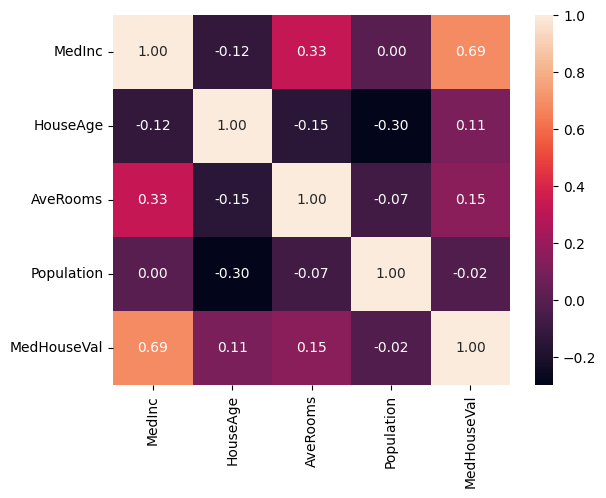

In [136]:
# Criar um heatmap (mapa de calor) que representa as correlações entre as variáveis de uma lista especificada

list1 = ["MedInc", "HouseAge", "AveRooms", "Population", "MedHouseVal"]
sns.heatmap(df[list1].corr(), annot = True, fmt = ".2f")
plt.show()

## Classificação Automática

Para este requisito, temos como objetivo criar um modelo para prever o median_house_value (valor mediano das casas), usando as demais variáveis do dataset como suporte (ex.: median_income, housing_median_age, population, etc.).

### Definição de threshold

In [137]:
# Definir um valor de base das casas
threshold_value = 2.5
df['HighValue'] = (df['MedHouseVal'] > threshold_value).astype(int)

# Check distribution
df['HighValue'].value_counts()

0    14858
1     5782
Name: HighValue, dtype: int64

### Definição de features e resultados a atingir

In [138]:
# Colunas a utilizar para obter resultados

feature_cols = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'Population',
    'AveOccup',
    'Latitude',
    'Longitude'
]

X = df[feature_cols].copy()
y = df['HighValue']

### Definição de testes do modelo

In [139]:
# Definição de treino do modelo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [140]:
# Definir apenas uma escala de dados a utilizar

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Lógica de regressão

Logistic Regression - Accuracy: 0.8524709302325582
Logistic Regression - F1 Score: 0.7142186766776162
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2972
           1       0.78      0.66      0.71      1156

    accuracy                           0.85      4128
   macro avg       0.83      0.79      0.81      4128
weighted avg       0.85      0.85      0.85      4128



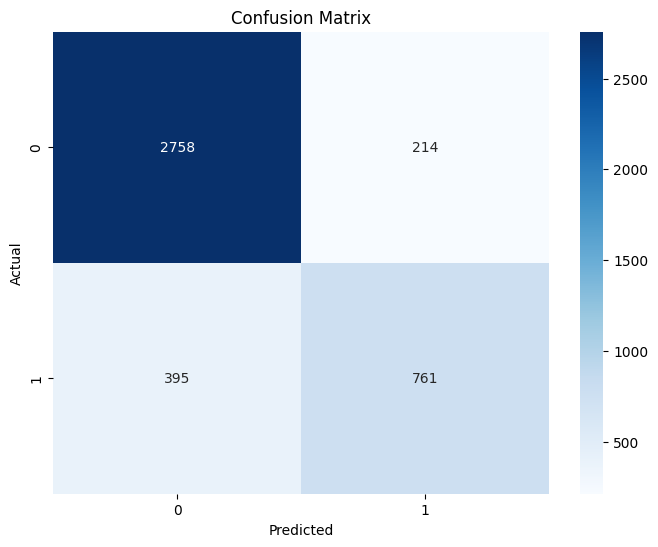

In [141]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

acc_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg  = f1_score(y_test, y_pred_logreg)

print("Logistic Regression - Accuracy:", acc_logreg)
print("Logistic Regression - F1 Score:", f1_logreg)

# Classification Report
print(classification_report(y_test,y_pred_logreg))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

Random Forest - Best Params: {'max_depth': None, 'n_estimators': 100}
Random Forest - Accuracy: 0.9009205426356589
Random Forest - F1 Score: 0.812299219825608
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2972
           1       0.87      0.77      0.81      1156

    accuracy                           0.90      4128
   macro avg       0.89      0.86      0.87      4128
weighted avg       0.90      0.90      0.90      4128



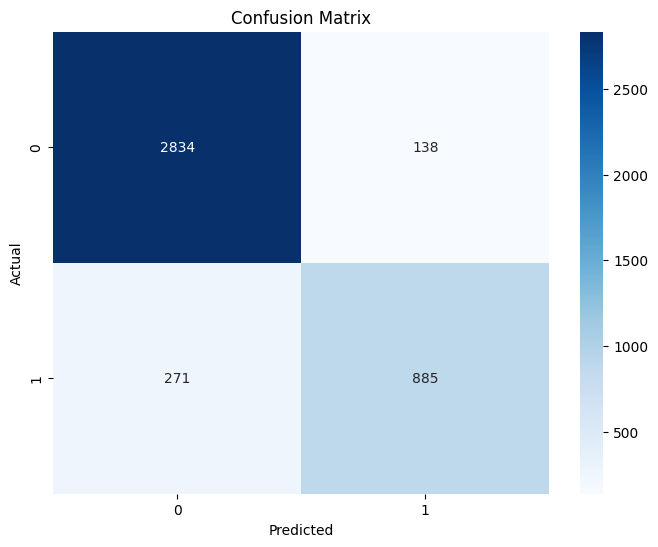

In [142]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)

print("Random Forest - Best Params:", grid_rf.best_params_)
print("Random Forest - Accuracy:", acc_rf)
print("Random Forest - F1 Score:", f1_rf)

# Classification Report
print(classification_report(y_test,y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### DecisionTreeClassifier

Decision Tree - Best Params: {'max_depth': None, 'min_samples_split': 10}
Decision Tree - Accuracy: 0.8660368217054264
Decision Tree - F1 Score: 0.7592511972137571

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      2972
           1       0.76      0.75      0.76      1156

    accuracy                           0.87      4128
   macro avg       0.83      0.83      0.83      4128
weighted avg       0.87      0.87      0.87      4128

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2972
           1       0.76      0.75      0.76      1156

    accuracy                           0.87      4128
   macro avg       0.83      0.83      0.83      4128
weighted avg       0.87      0.87      0.87      4128



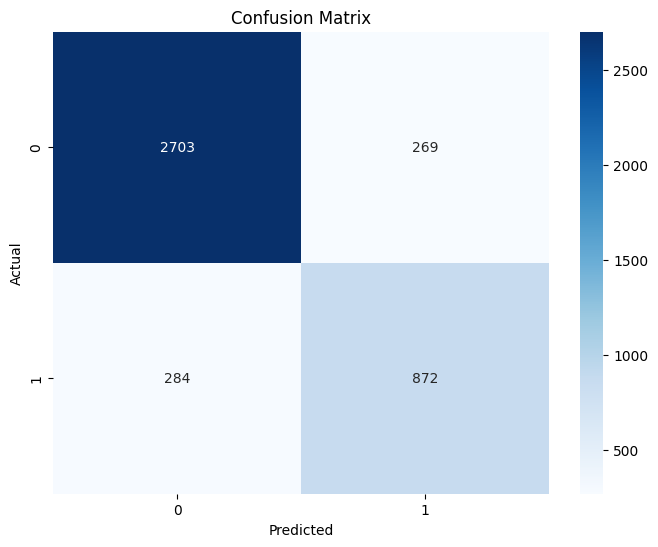

In [143]:
# Example parameter grid for DecisionTreeClassifier
param_grid_dtc = {
    'max_depth': [3, 6, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize a basic DecisionTreeClassifier (we'll tune it via GridSearch)
dtc = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_dtc = GridSearchCV(
    dtc, 
    param_grid_dtc, 
    cv=3,               # 3-fold cross-validation
    scoring='f1',       # or 'accuracy', 'precision', etc.
    n_jobs=-1           # use all CPU cores
)

# Fit on training data (scaled or unscaled, depending on your workflow)
grid_dtc.fit(X_train_scaled, y_train)

# Retrieve the best model from the grid search
best_dtc = grid_dtc.best_estimator_

# Predict on the test set
y_pred_dtc = best_dtc.predict(X_test_scaled)

# Evaluate performance
acc_dtc = accuracy_score(y_test, y_pred_dtc)
f1_dtc  = f1_score(y_test, y_pred_dtc)

print("Decision Tree - Best Params:", grid_dtc.best_params_)
print("Decision Tree - Accuracy:", acc_dtc)
print("Decision Tree - F1 Score:", f1_dtc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dtc))

# Classification Report
print(classification_report(y_test,y_pred_dtc))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dtc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Comparação de Modelos

In [144]:
print("\n=== Final Comparison ===")
print(f"Logistic Regression -> F1 = {f1_logreg:.3f}")
print(f"Random Forest       -> F1 = {f1_rf:.3f}")
print(f"DecisionTreeClassifier -> F1 = {f1_dtc:.3f}")

if f1_dtc >= f1_rf and f1_xgb >= f1_logreg:
    final_model = best_dtc
    chosen_name = "DecisionTreeClassifier"
elif f1_rf >= f1_logreg:
    final_model = best_rf
    chosen_name = "Random Forest"
else:
    final_model = logreg
    chosen_name = "Logistic Regression"

print(f"\nSelected model: {chosen_name}")


=== Final Comparison ===
Logistic Regression -> F1 = 0.714
Random Forest       -> F1 = 0.812
DecisionTreeClassifier -> F1 = 0.759

Selected model: Random Forest


## Clustering

In [145]:
X_cluster = df[[
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'Population',
    'AveOccup'
]].copy()

# Caso haja algum NaN (valores ausentes), remover ou tratar
X_cluster.dropna(inplace=True)

In [146]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

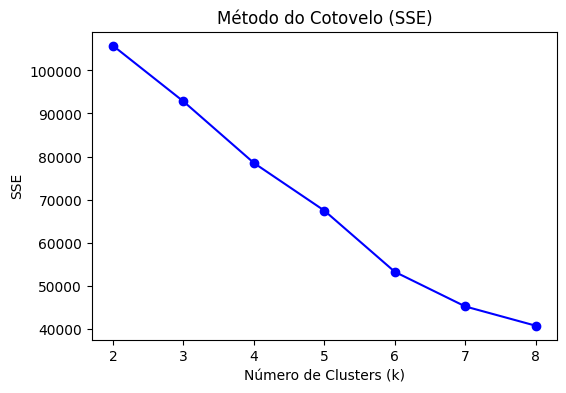

In [147]:
sse = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_cluster_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, sse, 'bo-')
plt.title('Método do Cotovelo (SSE)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE')
plt.show()

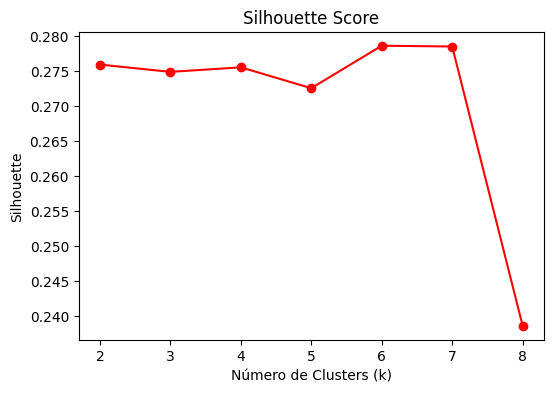

In [148]:
sil_scores = []
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, init='k-means++')
    labels_temp = kmeans_temp.fit_predict(X_cluster_scaled)
    sil = silhouette_score(X_cluster_scaled, labels_temp)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette')
plt.show()

In [149]:
k_opt = 5  # ou 4, 5, etc. baseado nos gráficos
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, init='k-means++')
kmeans_final.fit(X_cluster_scaled)

# Adiciona a coluna 'Cluster' ao DataFrame original
df['Cluster'] = kmeans_final.labels_

In [150]:
df['Cluster'].value_counts()

0    9929
1    7319
4    3389
2       2
3       1
Name: Cluster, dtype: int64

In [151]:
cluster_profile_mean = df.groupby('Cluster')[
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']
].mean()

print(cluster_profile_mean)

cluster_profile_std = df.groupby('Cluster')[
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']
].std()

print(cluster_profile_std)

cluster_profile_max = df.groupby('Cluster')[
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']
].max()

print(cluster_profile_max)

cluster_profile_min = df.groupby('Cluster')[
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']
].min()

print(cluster_profile_min)

            MedInc   HouseAge    AveRooms  AveBedrms   Population  \
Cluster                                                             
0         3.194593  38.268104    4.861427   1.058729  1059.569846   
1         3.403006  17.561552    5.135287   1.087440  2051.293619   
2         3.250000  33.500000  137.221212  29.851515    33.000000   
3        10.226400  45.000000    3.166667   0.833333  7460.000000   
4         6.859901  24.346415    7.649063   1.210900  1145.006492   

            AveOccup  MedHouseVal  
Cluster                            
0           2.947567     1.903408  
1           3.138781     1.713999  
2           2.563636     3.312505  
3        1243.333333     1.375000  
4           2.918482     3.317599  
           MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
Cluster                                                                    
0        1.147519   7.867560  0.963098   0.123234   525.440282  0.890319   
1        1.153832   7.010943  1.0997

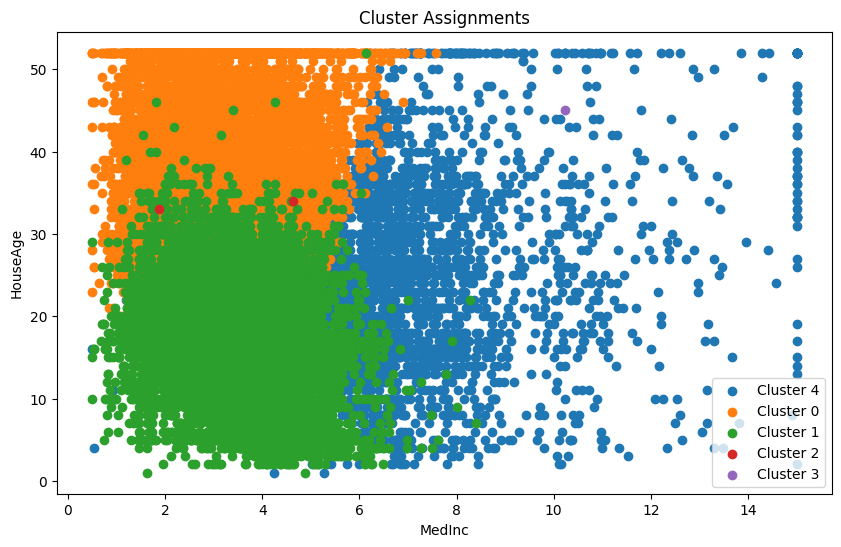

In [152]:
plt.figure(figsize=(10, 6))

# Suppose your DataFrame is called df and the cluster labels are in df['Cluster'].
for cluster_id in df['Cluster'].unique():
    # Filter rows that belong to the current cluster
    cluster_data = df[df['Cluster'] == cluster_id]
    
    plt.scatter(cluster_data['MedInc'],     # X-axis
                cluster_data['HouseAge'],   # Y-axis
                label=f'Cluster {cluster_id}')

plt.xlabel('MedInc')
plt.ylabel('HouseAge')
plt.title('Cluster Assignments')
plt.legend()
plt.show()


## Regras de Associação

Para as regras de associação, temos como objetivo encontrar combinações frequentes de características no dataset (renda, idade, ocupação, etc.) que se relacionem com casas de valor alto ou baixo.

### Binarização de colunas

In [153]:
df_assoc = df.copy()

# Example: define 'HighIncome' if MedInc > 3
df_assoc['HighIncome'] = np.where(df_assoc['MedInc'] > 3, 1, 0)

# Example: define 'OldHouse' if HouseAge > 30
df_assoc['OldHouse'] = np.where(df_assoc['HouseAge'] > 30, 1, 0)

# Example: define 'HighValueCat' if MedHouseVal > 2.5
df_assoc['HighValueCat'] = np.where(df_assoc['MedHouseVal'] > 2.5, 1, 0)

# Keep only these binary columns for association
df_assoc_binary = df_assoc[['HighIncome','OldHouse','HighValueCat']]


### Aplicação do Apriori

In [154]:
df_assoc_binary = df_assoc_binary.astype(bool)
freq_items = apriori(df_assoc_binary, min_support=0.2, use_colnames=True)
rules = association_rules(
    freq_items, 
    freq_items.shape[0], 
    metric="confidence", 
    min_threshold=0.5
)

# Sort by confidence or lift
rules.sort_values("confidence", ascending=False, inplace=True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,(HighValueCat),(HighIncome),0.280136,0.641328,0.256734,0.916465,1.429012,1.0,0.077076,4.293673,0.417045,0.386224,0.767099,0.658391
0,(OldHouse),(HighIncome),0.460029,0.641328,0.278440,0.605266,0.943770,1.0,-0.016589,0.908643,-0.099374,0.338357,-0.100542,0.519714


In [124]:
# Filtrar por lift
rules_filtered = rules[(rules['lift'] > 1.2)]
rules_filtered.sort_values("confidence", ascending=False, inplace=True)

print("Total de regras antes do filtro:", rules.shape[0])
print("Regras após filtro lift>1.2:", rules_filtered.shape[0])
print("Algumas regras relevantes:")
print(rules_filtered.head(10))

Total de regras antes do filtro: 2
Regras após filtro lift>1.2: 1
Algumas regras relevantes:
      antecedents   consequents  antecedent support  consequent support  \
1  (HighValueCat)  (HighIncome)            0.280136            0.641328   

    support  confidence      lift  representativity  leverage  conviction  \
1  0.256734    0.916465  1.429012               1.0  0.077076    4.293673   

   zhangs_metric   jaccard  certainty  kulczynski  
1       0.417045  0.386224   0.767099    0.658391  


/tmp/ipykernel_31/2862493576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_filtered.sort_values("confidence", ascending=False, inplace=True)


# Conclusão

O desenvolvimento deste projeto permitiu aplicar conceitos fundamentais de Inteligência Artificial na criação e implementação de um agente inteligente. 
Durante este processo, foi possível explorar técnicas de planeamento, otimização e resolução de problemas sob restrições, consolidando conhecimentos teóricos e práticos.
Foi programado um agente inteligente capaz de lidar com restrições fortes, como precedência de tarefas e capacidade de recursos, e restrições leves, como a minimização da duração total do calendário (makespan).
Estas restrições foram integradas de maneira a criar um modelo realista e aplicável a cenários complexos.
Ao longo do processo, explorámos diversos tipos de soluções, desde soluções possíveis, que podem violar restrições, até soluções viáveis e otimizadas, que garantem o cumprimento das condições definidas.
O agente foi desenhado para encontrar soluções com pontuações elevadas dentro de um tempo limitado, demonstrando a capacidade de identificar a melhor solução encontrada e, quando possível, soluções ótimas.
